In [1]:
import os
import torch
import numpy as np
import scipy.stats
from collections import defaultdict
from torch.distributions import constraints

import pyro
import pyro.distributions as dist

from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, infer_discrete
from pyro.util import ignore_jit_warnings

pyro.clear_param_store()
pyro.set_rng_seed(1)


In [2]:
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import skew
from scipy.spatial.distance import cityblock
import matplotlib.pyplot as plt
import seaborn as sns
from scgenome.cnplot import plot_clustered_cell_cn_matrix, plot_cell_cn_profile

from scdna_replication_tools.compute_consensus_clone_profiles import compute_consensus_clone_profiles
from scdna_replication_tools.assign_s_to_clones import assign_s_to_clones


In [3]:
cn_s = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/fig4/cn_s.tsv', sep='\t')
cn_g1 = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/fig4/cn_g1.tsv', sep='\t')
cn_g2 = pd.read_csv('/juno/work/shah/users/weinera2/projects/scdna_replication_paper/analysis/fig4/cn_g2.tsv', sep='\t')

cn_g = pd.concat([cn_g1, cn_g2], ignore_index=True)

cn_g.head()

,cell_id,chr,start,end,gc,reads,state,copy,rpm,sample_id,library_id,cell_cycle_state,quality,total_mapped_reads_hmmcopy,breakpoints
0,SA1044-A96139A-R03-C07,1,1500001,2000000,0.539498,561.0,2.0,1.889549,154.559292,SA1044,A96139A,G1,0.996,3700925.0,60.0
1,SA1044-A96139A-R03-C07,1,2000001,2500000,0.594508,591.0,2.0,2.072884,162.824495,SA1044,A96139A,G1,0.996,3700925.0,60.0
2,SA1044-A96139A-R03-C07,1,3000001,3500000,0.584572,574.0,2.0,1.989477,158.140880,SA1044,A96139A,G1,0.996,3700925.0,60.0
3,SA1044-A96139A-R03-C07,1,4000001,4500000,0.482574,603.0,2.0,2.072915,166.130576,SA1044,A96139A,G1,0.996,3700925.0,60.0
4,SA1044-A96139A-R03-C07,1,4500001,5000000,0.481828,608.0,2.0,2.091552,167.508110,SA1044,A96139A,G1,0.996,3700925.0,60.0


Subset to just 400 loci on chr1 and a random sampling of 300 cells

In [61]:
num_cells = 300
num_loci = 400

In [4]:
# subset based on loci
def subset_loci(cn, chrom="1", num_loci=400):
    cn = cn.query('chr=="{}"'.format(chrom))
    cutoff = cn[['start']].drop_duplicates().values[num_loci]
    cn = cn.query('start<{}'.format(cutoff))
    return cn

cn_s = subset_loci(cn_s, num_loci=num_loci)
cn_g = subset_loci(cn_g, num_loci=num_loci)

print(cn_s[['chr', 'start']].drop_duplicates().shape)
print(cn_g[['chr', 'start']].drop_duplicates().shape)
cn_s[['chr', 'start']].drop_duplicates().head()

(400, 2)
(400, 2)


,chr,start
0,1,1500001
1,1,2000001
2,1,3000001
3,1,4000001
4,1,4500001


In [5]:
# subset based on cells
def subset_cells(cn, num_cells=300):
    cells_to_keep = np.random.choice(cn['cell_id'].unique(), num_cells, replace=False)
    cn = cn.loc[cn['cell_id'].isin(cells_to_keep)].reset_index(drop=True)
    return cn

cn_s = subset_cells(cn_s, num_cells=num_cells)
cn_g = subset_cells(cn_g, num_cells=num_cells)

cn_s.head()

,cell_id,chr,start,end,gc,reads,state,copy,rpm,sample_id,library_id,cell_cycle_state,quality,total_mapped_reads_hmmcopy,breakpoints
0,SA1044-A96139A-R03-C36,1,1500001,2000000,0.539498,496.0,2.0,1.599267,130.279847,SA1044,A96139A,S,1.0,3882694.0,122.0
1,SA1044-A96139A-R03-C36,1,2000001,2500000,0.594508,564.0,2.0,2.017618,148.140794,SA1044,A96139A,S,1.0,3882694.0,122.0
2,SA1044-A96139A-R03-C36,1,3000001,3500000,0.584572,643.0,2.0,2.240401,168.891011,SA1044,A96139A,S,1.0,3882694.0,122.0
3,SA1044-A96139A-R03-C36,1,4000001,4500000,0.482574,629.0,2.0,2.001553,165.213757,SA1044,A96139A,S,1.0,3882694.0,122.0
4,SA1044-A96139A-R03-C36,1,4500001,5000000,0.481828,606.0,2.0,1.929176,159.172555,SA1044,A96139A,S,1.0,3882694.0,122.0


In [6]:
cn_s_metrics = cn_s[[
    'cell_id', 'sample_id', 'library_id', 'cell_cycle_state', 
    'quality', 'total_mapped_reads_hmmcopy', 'breakpoints'
]].drop_duplicates()

cn_g_metrics = cn_g[[
    'cell_id', 'sample_id', 'library_id', 'cell_cycle_state', 
    'quality', 'total_mapped_reads_hmmcopy', 'breakpoints'
]].drop_duplicates()

print(cn_s_metrics.library_id.value_counts())
print(cn_g_metrics.library_id.value_counts())

A96139A    107
A90553C     81
A96147A     56
A73044A     56
Name: library_id, dtype: int64
A96147A    81
A90553C    79
A96139A    71
A73044A    69
Name: library_id, dtype: int64


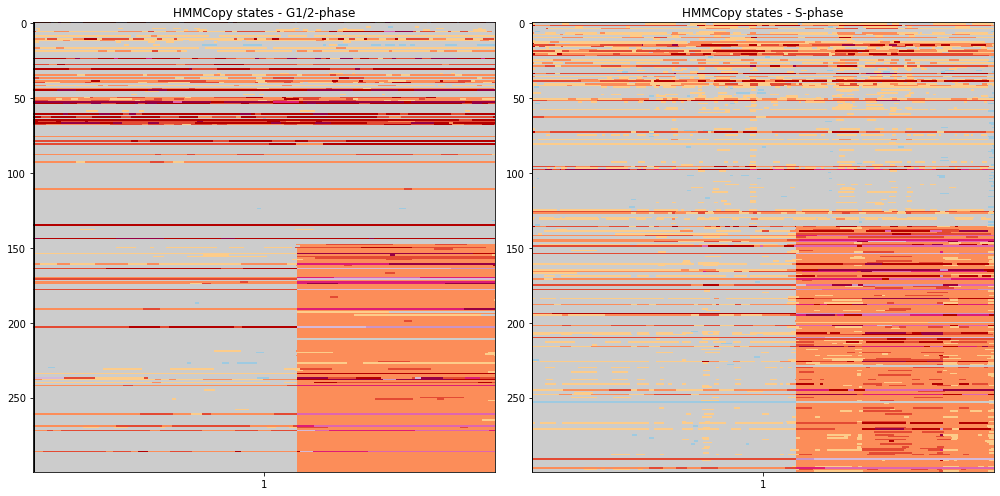

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), tight_layout=True)
ax = ax.flatten()

plot_clustered_cell_cn_matrix(ax[0], cn_g, 'state', cluster_field_name='library_id', secondary_field_name='total_mapped_reads_hmmcopy')
plot_clustered_cell_cn_matrix(ax[1], cn_s, 'state', cluster_field_name='library_id', secondary_field_name='total_mapped_reads_hmmcopy')

ax[0].set_title('HMMCopy states - G1/2-phase')
ax[1].set_title('HMMCopy states - S-phase')
plt.show()

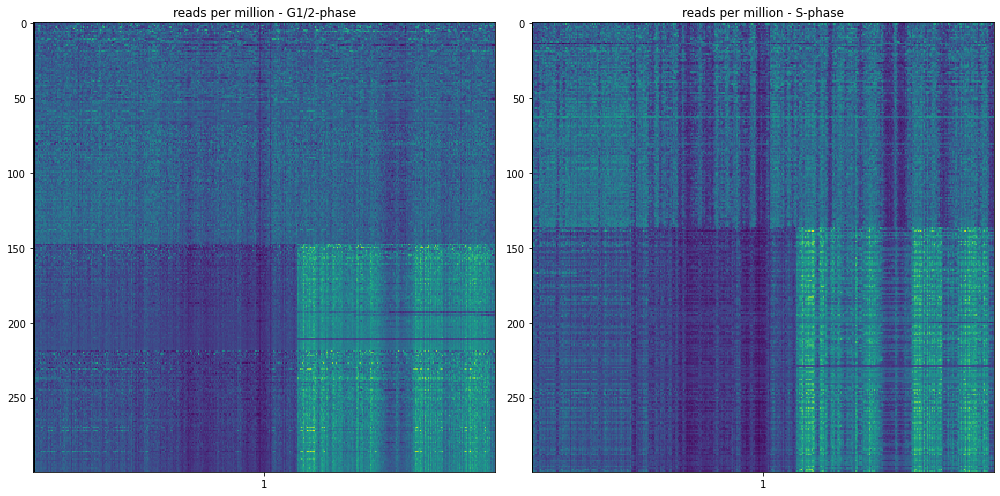

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7), tight_layout=True)
ax = ax.flatten()

plot_clustered_cell_cn_matrix(ax[0], cn_g, 'rpm', max_cn=None, raw=True, cmap='viridis', cluster_field_name='library_id', secondary_field_name='total_mapped_reads_hmmcopy')
plot_clustered_cell_cn_matrix(ax[1], cn_s, 'rpm', max_cn=None, raw=True, cmap='viridis', cluster_field_name='library_id', secondary_field_name='total_mapped_reads_hmmcopy')

ax[0].set_title('reads per million - G1/2-phase')
ax[1].set_title('reads per million - S-phase')
plt.show()

Is it an issue that I'm using reads per million normalized to the entire genome instead of normalized to the set of 400 loci used in this analysis?

Say that each S-phase cell's clone_id is the same as its sample_id. We cannot use `compute_consensus_clone_profiles()` and `assign_s_to_clones()` in this toy example because the lack of CNAs across the whole genome makes it more challenging to assign individual S-phase cells to the correct consensus profile.

In [9]:
cn_s['clone_id'] = cn_s['sample_id']
cn_g['clone_id'] = cn_g['sample_id']
cn_s.head()

,cell_id,chr,start,end,gc,reads,state,copy,rpm,sample_id,library_id,cell_cycle_state,quality,total_mapped_reads_hmmcopy,breakpoints,clone_id
0,SA1044-A96139A-R03-C36,1,1500001,2000000,0.539498,496.0,2.0,1.599267,130.279847,SA1044,A96139A,S,1.0,3882694.0,122.0,SA1044
1,SA1044-A96139A-R03-C36,1,2000001,2500000,0.594508,564.0,2.0,2.017618,148.140794,SA1044,A96139A,S,1.0,3882694.0,122.0,SA1044
2,SA1044-A96139A-R03-C36,1,3000001,3500000,0.584572,643.0,2.0,2.240401,168.891011,SA1044,A96139A,S,1.0,3882694.0,122.0,SA1044
3,SA1044-A96139A-R03-C36,1,4000001,4500000,0.482574,629.0,2.0,2.001553,165.213757,SA1044,A96139A,S,1.0,3882694.0,122.0,SA1044
4,SA1044-A96139A-R03-C36,1,4500001,5000000,0.481828,606.0,2.0,1.929176,159.172555,SA1044,A96139A,S,1.0,3882694.0,122.0,SA1044


### Convert dataframes into appropriate tensors much like `pyro_infer_scRT.process_input_data()`

In [10]:
def process_input_data(
    cn_s, cn_g1, input_col='rpm', cell_col='cell_id', gc_col='gc',
    chr_col='chr', start_col='start', cn_state_col='state', rt_prior_col=None
):
    # sort rows by correct genomic ordering
    cn_g1 = sort_by_cell_and_loci(cn_g1, chr_col=chr_col, start_col=start_col, cell_col=cell_col)
    cn_s = sort_by_cell_and_loci(cn_s, chr_col=chr_col, start_col=start_col, cell_col=cell_col)

    # drop any row where read count input is NaN
    cn_g1 = cn_g1[cn_g1[input_col].notna()]
    cn_s = cn_s[cn_s[input_col].notna()]

    # pivot to 2D matrix where each row is a unique cell, columns are loci
    cn_g1_reads_df = cn_g1.pivot_table(index=cell_col, columns=[chr_col, start_col], values=input_col)
    cn_g1_states_df = cn_g1.pivot_table(index=cell_col, columns=[chr_col, start_col], values=cn_state_col)
    cn_s_reads_df = cn_s.pivot_table(index=cell_col, columns=[chr_col, start_col], values=input_col)
    cn_s_states_df = cn_s.pivot_table(index=cell_col, columns=[chr_col, start_col], values=cn_state_col)

    cn_g1_reads_df = cn_g1_reads_df.dropna()
    cn_g1_states_df = cn_g1_states_df.dropna()
    cn_s_reads_df = cn_s_reads_df.dropna()
    cn_s_states_df = cn_s_states_df.dropna()

    assert cn_g1_states_df.shape == cn_g1_reads_df.shape
    assert cn_s_reads_df.shape[1] == cn_g1_reads_df.shape[1]

    cn_g1_reads_df = cn_g1_reads_df.T
    cn_g1_states_df = cn_g1_states_df.T
    cn_s_reads_df = cn_s_reads_df.T
    cn_s_states_df = cn_s_states_df.T

    # convert to tensor and unsqueeze the data dimension
    # convert to int64 before float32 to ensure that all values are rounded to the nearest int
    cn_g1_reads = torch.tensor(cn_g1_reads_df.values).to(torch.int64).to(torch.float32)
    cn_g1_states = torch.tensor(cn_g1_states_df.values).to(torch.int64).to(torch.float32)
    cn_s_reads = torch.tensor(cn_s_reads_df.values).to(torch.int64).to(torch.float32)
    cn_s_states = torch.tensor(cn_s_states_df.values).to(torch.int64).to(torch.float32)

    # get tensor of library_id index
    # need this because each library will have unique gc params
    libs_s, libs_g1 = get_libraries_tensor(cn_s, cn_g1)

    # make sure there's one library index per cell
    assert libs_s.shape[0] == cn_s_reads.shape[1]
    assert libs_g1.shape[0] == cn_g1_reads.shape[1]

    # get tensor for GC profile
    gc_profile = cn_s[[chr_col, start_col, gc_col]].drop_duplicates()
    gc_profile = gc_profile.dropna()
    gc_profile = torch.tensor(gc_profile[gc_col].values).to(torch.float32)

    # get tensor for rt prior if provided
    if (rt_prior_col is not None) and (rt_prior_col in cn_s.columns):
        rt_prior_profile = cn_s[[chr_col, start_col, rt_prior_col]].drop_duplicates()
        rt_prior_profile = rt_prior_profile.dropna()
        rt_prior_profile = torch.tensor(rt_prior_profile[rt_prior_col].values).unsqueeze(-1).to(torch.float32)
        rt_prior_profile = convert_rt_prior_units(rt_prior_profile)
        assert cn_s_reads.shape[0] == gc_profile.shape[0] == rt_prior_profile.shape[0]
    else:
        rt_prior_profile = None

    return cn_g1_reads_df, cn_g1_states_df, cn_s_reads_df, cn_s_states_df, cn_g1_reads, cn_g1_states, cn_s_reads, cn_s_states, gc_profile, rt_prior_profile, libs_g1, libs_s


def sort_by_cell_and_loci(cn, chr_col='chr', start_col='start', cell_col='cell_id'):
    """ Sort long-form dataframe so each cell follows correct genomic ordering """
    cn[chr_col] = cn[chr_col].astype('category')
    chr_order = [str(i+1) for i in range(22)]
    chr_order.append('X')
    chr_order.append('Y')
    cn[chr_col] = cn[chr_col].cat.set_categories(chr_order)
    cn = cn.sort_values(by=[cell_col, chr_col, start_col])
    return cn


def get_libraries_tensor(cn_s, cn_g1, cell_col='cell_id', library_col='library_id'):
    """ Create a tensor of integers representing the unique library_id of each cell. """
    libs_s = cn_s[[cell_col, library_col]].drop_duplicates()
    libs_g1 = cn_g1[[cell_col, library_col]].drop_duplicates()

    # get all unique library ids found across cells of both cell cycle phases
    all_library_ids = pd.concat([libs_s, libs_g1])[library_col].unique()

    num_libraries = int(len(all_library_ids))

    # replace library_id strings with integer values
    for i, library_id in enumerate(all_library_ids):
        libs_s[library_col].replace(library_id, i, inplace=True)
        libs_g1[library_col].replace(library_id, i, inplace=True)

    # convert to tensors of type int (ints needed to index other tensors)
    libs_s = torch.tensor(libs_s[library_col].values).to(torch.int64)
    libs_g1 = torch.tensor(libs_g1[library_col].values).to(torch.int64)

    return libs_s, libs_g1


def convert_rt_prior_units(rt_prior_profile):
    """ Make sure that early RT regions are close to 1, late RT regions are close to 0 """
    rt_prior_profile = rt_prior_profile / max(rt_prior_profile)
    return rt_prior_profile

In [11]:
cn_g1_reads_df, cn_g1_states_df, cn_s_reads_df, cn_s_states_df, \
    cn_g1_reads, cn_g1_states, cn_s_reads, cn_s_states, \
    gc_profile, rt_prior_profile, libs_g1, libs_s = process_input_data(cn_s, cn_g)

In [12]:
cn_s_reads

tensor([[130., 156., 242.,  ..., 339., 246., 230.],
        [148., 184., 231.,  ..., 191., 252., 194.],
        [168., 187., 183.,  ..., 249., 161., 195.],
        ...,
        [162., 198., 226.,  ..., 116., 224., 133.],
        [110., 211., 215.,  ...,  61.,  64., 102.],
        [141., 236., 202.,  ..., 142.,  96., 163.]])

In [13]:
libs_s

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [14]:
cn_s_reads_df.head()

cell_id      SA1044-A96139A-R03-C36  SA1044-A96139A-R04-C24  \
chr start                                                     
1   1500001              130.279847              156.619256   
    2000001              148.140794              184.720328   
    3000001              168.891011              187.667992   
    4000001              165.213757              172.929668   
    4500001              159.172555              184.720328   

cell_id      SA1044-A96139A-R04-C26  SA1044-A96139A-R05-C23  \
chr start                                                     
1   1500001              242.892800              181.948453   
    2000001              231.403075              184.773740   
    3000001              183.605816              228.659857   
    4000001              164.992460              208.506147   
    4500001              157.409242              151.435359   

cell_id      SA1044-A96139A-R05-C28  SA1044-A96139A-R06-C24  \
chr start                                                     
1   1500001              218.104116              170.394946   
    2000001              244.563887              170.813607   
    3000001              224.908057              173.116241   
    4000001              165.940566              173.325571   
    4500001              129.463882              166.836329   

cell_id      SA1044-A96139A-R07-C23  SA1044-A96139A-R07-C24  \
chr start                                                     
1   1500001              154.518331              145.400092   
    2000001              183.308303              159.066357   
    3000001              174.926412              199.169002   
    4000001              155.611621              170.268213   
    4500001              189.868044              114.707006   

cell_id      SA1044-A96139A-R08-C30  SA1044-A96139A-R09-C29  ...  \
chr start                                                    ...   
1   1500001              191.722309              185.812039  ...   
    2000001              175.321286              217.157722  ...   
    3000001              235.081337              235.254199  ...   
    4000001              201.713737              149.942237  ...   
    4500001              100.291316              115.041888  ...   

cell_id      SA928-A90553C-R64-C44  SA928-A90553C-R64-C51  \
chr start                                                   
1   1500001             184.554385             192.246997   
    2000001             242.175437             211.168945   
    3000001             223.803507             254.310988   
    4000001             253.031577             230.847771   
    4500001             151.985964             272.476058   

cell_id      SA928-A90553C-R65-C41  SA928-A90553C-R65-C48  \
chr start                                                   
1   1500001             191.855688             274.667351   
    2000001             220.137204             244.547172   
    3000001             224.723395             185.023960   
    4000001             264.470390             176.418194   
    4500001             174.275286             178.569636   

cell_id      SA928-A90553C-R65-C50  SA928-A90553C-R66-C41  \
chr start                                                   
1   1500001             227.840098             241.991459   
    2000001             246.701034             227.500953   
    3000001             186.346041             163.742724   
    4000001             153.905232             156.497471   
    4500001             153.905232             153.599369   

cell_id      SA928-A90553C-R66-C54  SA928-A90553C-R67-C44  \
chr start                                                   
1   1500001             230.899883             339.580389   
    2000001             203.504982             191.715054   
    3000001             242.640555             249.841427   
    4000001             337.870451             243.722862   
    4500001             206.114020             174.379119   

cell_id      SA928-A90553C-R67-C47  SA928-A

### build cn prior tensor using consensus clone profiles

In [15]:
def build_cn_prior(cn, weight=1e6, num_states=13):
    """ Build a prior for each bin's cn state based on its value in cn. """
    num_loci, num_cells = cn.shape
    cn_prior = torch.ones(num_loci, num_cells, num_states)
    for i in range(num_loci):
        for n in range(num_cells):
            state = int(cn[i, n].numpy())
            cn_prior[i, n, state] = weight
    return cn_prior

In [16]:
# use G1-phase clone that has highest correlation to each S-phase cell as prior
# compute consensuse clone profiles for cn state
clone_cn_profiles = compute_consensus_clone_profiles(
    cn_g, 'state', clone_col='clone_id', cell_col='cell_id', chr_col='chr',
    start_col='start', cn_state_col='state'
)

cn_prior_input = torch.zeros(cn_s_states.shape)

for i, cell_id in enumerate(cn_s_reads_df.columns):
    cell_cn = cn_s.loc[cn_s['cell_id']==cell_id]  # get full cn data for this cell
    cell_clone = cell_cn['clone_id'].values[0]  # get clone id
    cn_prior_input[:, i] = torch.tensor(clone_cn_profiles[cell_clone].values).to(torch.int64).to(torch.float32)  # assign consensus clone cn profile for this cell

# build a proper prior over num_states using the consensus clone cn calls for each cell
cn_prior = build_cn_prior(cn_prior_input)
cn_prior.shape

cn.columns 1
 Index(['cell_id', 'chr', 'start', 'end', 'gc', 'reads', 'state', 'copy', 'rpm',
       'sample_id', 'library_id', 'cell_cycle_state', 'quality',
       'total_mapped_reads_hmmcopy', 'breakpoints', 'clone_id'],
      dtype='object')
cn.head 1
                   cell_id chr    start      end        gc  reads  state  \
0  SA1044-A96139A-R03-C09   1  1500001  2000000  0.539498  551.0    2.0   
1  SA1044-A96139A-R03-C09   1  2000001  2500000  0.594508  577.0    2.0   
2  SA1044-A96139A-R03-C09   1  3000001  3500000  0.584572  634.0    2.0   
3  SA1044-A96139A-R03-C09   1  4000001  4500000  0.482574  605.0    2.0   
4  SA1044-A96139A-R03-C09   1  4500001  5000000  0.481828  611.0    2.0   

       copy         rpm sample_id library_id cell_cycle_state  quality  \
0  1.857108  149.395166    SA1044    A96139A               G1    0.994   
1  2.055581  156.444666    SA1044    A96139A               G1    0.994   
2  2.224632  171.899339    SA1044    A96139A               G1    0.994

torch.Size([400, 300, 13])

### Define generative model for G1-phase cells

In [17]:
def make_gc_features(x, poly_degree=4):
    """Builds features i.e. a matrix with columns [x, x^2, x^3, x^4]."""
    x = x.unsqueeze(1)
    return torch.cat([x ** i for i in reversed(range(0, poly_degree+1))], 1)


In [18]:

@config_enumerate
def model_g2(gc_profile, libs, cn=None, num_cells=None, num_loci=None, data=None, poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn is not None:
            num_loci, num_cells = cn.shape
        assert num_cells is not None
        assert num_loci is not None
        num_libraries = int(torch.max(libs).item() + 1)

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

    # gc bias params
    beta_means = pyro.sample('expose_beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('expose_beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)

    with pyro.plate('num_cells', num_cells):

        # per cell reads per copy per bin
        # u should be inversely related to cn, positively related to reads
        if (data is not None) and (cn is not None):
            cell_ploidies = torch.mean(cn.type(torch.float32), dim=0)
            u_guess = torch.mean(data.type(torch.float32), dim=0) / cell_ploidies
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.

        u = pyro.sample('expose_u', dist.Normal(u_guess, u_stdev))
        
        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('expose_betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))
        
        with pyro.plate('num_loci', num_loci):

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            # gc_rate = gc_rate / torch.mean(gc_rate)
            biased_cn = cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)

            if data is not None:
                obs = data
            else:
                obs = None

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

### Infer latent parameters for the G1-phase model fit to data

In [19]:
conditioned_model_g2 = poutine.condition(
    model_g2,
    data={
    })

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=2)

guide_g2 = AutoDelta(
    poutine.block(conditioned_model_g2, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi = SVI(conditioned_model_g2, guide_g2, optim, loss=elbo)


In [20]:
elbo.loss(conditioned_model_g2, guide_g2, gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)

3847206.5

In [21]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)
    
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

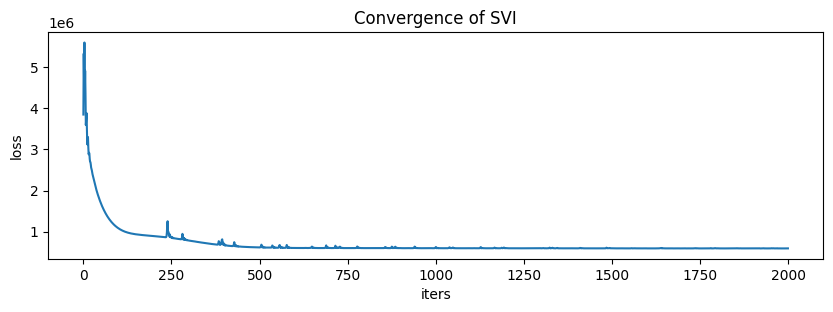

In [22]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');

In [23]:
# replay model
guide_trace_g2 = poutine.trace(guide_g2).get_trace(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)
trained_model_g2 = poutine.replay(model_g2, trace=guide_trace_g2)

# infer discrete sites and get model trace
inferred_model_g2 = infer_discrete(
    trained_model_g2, temperature=0,
    first_available_dim=-3)
trace_g2 = poutine.trace(inferred_model_g2).get_trace(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads)

# extract fitted parameters
nb_r_fit2 = trace_g2.nodes['expose_nb_r']['value']
betas_fit2 = trace_g2.nodes['expose_betas']['value']
beta_means_fit2 = trace_g2.nodes['expose_beta_means']['value']
beta_stds_fit2 = trace_g2.nodes['expose_beta_stds']['value']
u_fit2 = trace_g2.nodes['expose_u']['value']

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/discrete.py:99: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  "infer_discrete found no sample sites configured for enumeration. "


In [24]:
beta_means_fit2.shape, beta_stds_fit2.shape, betas_fit2.shape

(torch.Size([4, 5]), torch.Size([4, 5]), torch.Size([300, 5]))

In [25]:
u_fit2.shape

torch.Size([300])

### Vizualise the model output after being fit to G1/2 phase cells

300


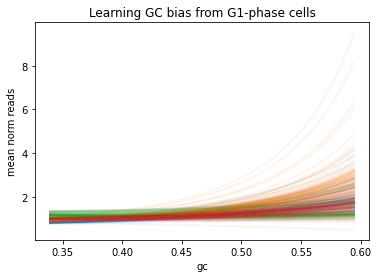

In [26]:
num_cells = cn_g1_reads.shape[1]
print(num_cells)
x = np.linspace(min(gc_profile), max(gc_profile), 101)  # gc values

# true gc betas
for i in range(num_cells):
    # inferred gc betas
    p1d_fit = np.poly1d(betas_fit2[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    library_index = libs_g1[i]
    plt.plot(x, mean_fit, 'C{}'.format(library_index), alpha=0.1)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Learning GC bias from G1-phase cells')
plt.show()

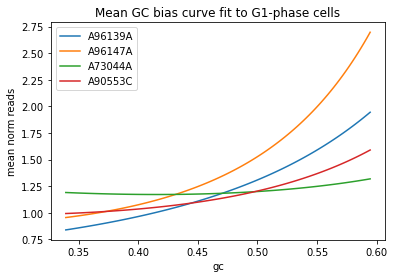

In [27]:
# plot mean gc bias curve for each library
for i, library_id in enumerate(cn_g1.library_id.unique()):
    # inferred gc betas
    p1d_fit = np.poly1d(beta_means_fit2[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    plt.plot(x, mean_fit, 'C{}'.format(i), label=library_id)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Mean GC bias curve fit to G1-phase cells')
plt.legend()
plt.show()

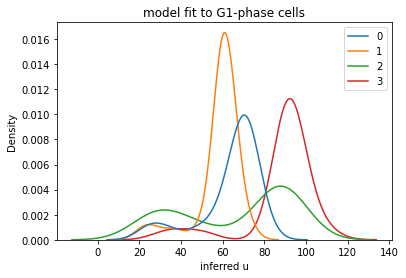

In [28]:
sns.kdeplot(x=u_fit2.detach().numpy(), hue=libs_g1.detach().numpy().astype(str))
plt.title('model fit to G1-phase cells')
plt.xlabel('inferred u');

These gc bias curves above look fairly reasonable and seem to match intuition much better than ther results I got earlier. It's possible that this is the product of having a cell-specific `u_guess` incorporated into the model based on each cell's ploidy rather than a global `u_guess` for all the cells

### See what the model output looks like when I give the model a global `u_guess` like I did within pyro_model.py

In [29]:
def model_g1(gc_profile, libs, cn=None, num_cells=None, num_loci=None, data=None, u_guess=70., poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn is not None:
            num_loci, num_cells = cn.shape
        assert num_cells is not None
        assert num_loci is not None
        num_libraries = int(torch.max(libs).item() + 1)

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([10000.0]), constraint=constraints.positive)

    # gc bias params
    beta_means = pyro.sample('expose_beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('expose_beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)

    with pyro.plate('num_cells', num_cells):

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([u_guess]), torch.tensor([u_guess/10.])))

        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('expose_betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))

        with pyro.plate('num_loci', num_loci):

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            biased_cn = cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)

            if data is not None:
                obs = data
            else:
                obs = None

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

In [30]:
u_guess_g1 = torch.mean(cn_g1_reads) / torch.mean(cn_g1_states)
u_guess_g1

tensor(67.2892)

In [31]:
pyro.clear_param_store()

conditioned_model_g1 = poutine.condition(
    model_g1,
    data={
    })

optim = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo = Trace_ELBO(max_plate_nesting=2)

guide_g1 = AutoDelta(
    poutine.block(conditioned_model_g1, expose_fn=lambda msg: msg["name"].startswith("expose_"))
)

svi = SVI(conditioned_model_g1, guide_g1, optim, loss=elbo)


In [32]:
elbo.loss(conditioned_model_g1, guide_g1, gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads, u_guess=u_guess_g1)

3075816.25

In [33]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi.step(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads, u_guess=u_guess_g1)
    
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break
    
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')



...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

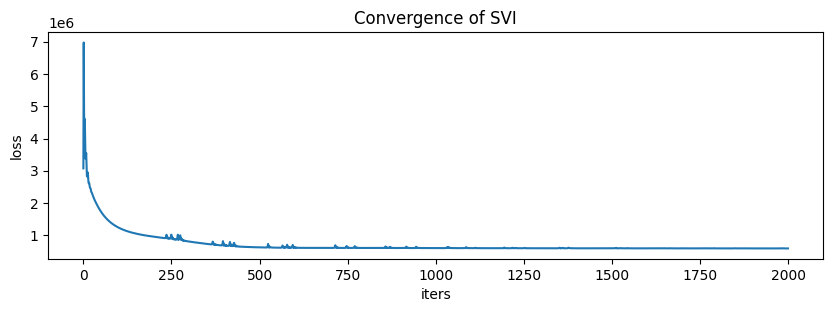

In [34]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');

In [35]:
# replay model
guide_trace_g1 = poutine.trace(guide_g1).get_trace(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads, u_guess=u_guess_g1)
trained_model_g1 = poutine.replay(model_g1, trace=guide_trace_g1)

# infer discrete sites and get model trace
inferred_model_g1 = infer_discrete(
    trained_model_g1, temperature=0,
    first_available_dim=-3)
trace_g1 = poutine.trace(inferred_model_g1).get_trace(gc_profile, libs_g1, cn=cn_g1_states, data=cn_g1_reads, u_guess=u_guess_g1)

# extract fitted parameters
nb_r_fit = trace_g1.nodes['expose_nb_r']['value']
betas_fit = trace_g1.nodes['expose_betas']['value']
beta_means_fit = trace_g1.nodes['expose_beta_means']['value']
beta_stds_fit = trace_g1.nodes['expose_beta_stds']['value']
u_fit = trace_g1.nodes['expose_u']['value']

/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/infer/discrete.py:99: UserWarning: infer_discrete found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}.
  "infer_discrete found no sample sites configured for enumeration. "


300


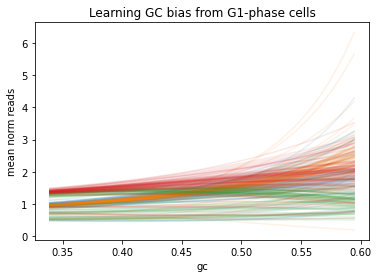

In [36]:
num_cells = cn_g1_reads.shape[1]
print(num_cells)
x = np.linspace(min(gc_profile), max(gc_profile), 101)  # gc values

# true gc betas
for i in range(num_cells):
    # inferred gc betas
    p1d_fit = np.poly1d(betas_fit[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    library_index = libs_g1[i]
    plt.plot(x, mean_fit, 'C{}'.format(library_index), alpha=0.1)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Learning GC bias from G1-phase cells')
plt.show()

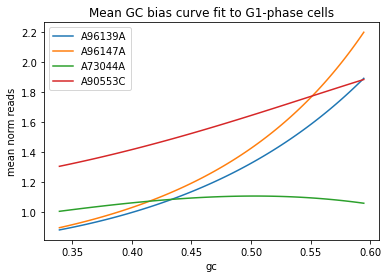

In [37]:
# plot mean gc bias curve for each library
for i, library_id in enumerate(cn_g1.library_id.unique()):
    # inferred gc betas
    p1d_fit = np.poly1d(beta_means_fit[i].detach().numpy())
    mean_fit = np.exp(p1d_fit(x))
    plt.plot(x, mean_fit, 'C{}'.format(i), label=library_id)

plt.xlabel('gc')
plt.ylabel('mean norm reads')
plt.title('Mean GC bias curve fit to G1-phase cells')
plt.legend()
plt.show()

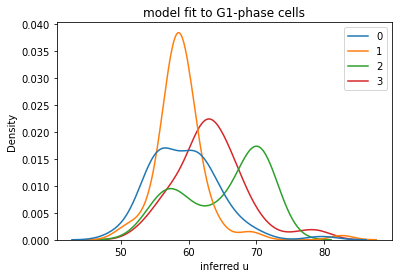

In [38]:
sns.kdeplot(x=u_fit.detach().numpy(), hue=libs_g1.detach().numpy().astype(str))
plt.title('model fit to G1-phase cells')
plt.xlabel('inferred u');

We're starting to see a separation of inferred `u` values based on library_id values. Keep in mind that both the `A96...` libraries are T-47D cells but the orange curve has lower `u` and higher absolute GC bias whereas the blue curve has higher `u` and lower absolute GC bias.

### Try to recreate the error in estimating the correct `time` in S-phase cells by using the betas learned from model_g1

In [39]:
@config_enumerate
def model_s1(gc_profile, libs, cn0=None, rt0=None, num_cells=None, num_loci=None, data=None, trans_mat=None, cn_prior=None, u_guess=70., nb_r_guess=10000., poly_degree=4):
    with ignore_jit_warnings():
        if data is not None:
            num_loci, num_cells = data.shape
        elif cn0 is not None:
            num_loci, num_cells = cn0.shape
        assert num_cells is not None
        assert num_loci is not None
        num_libraries = int(torch.max(libs).item() + 1)

    # controls the consistency of replicating on time
    a = pyro.sample('expose_a', dist.Gamma(torch.tensor([2.]), torch.tensor([0.2])))

    # negative binomial dispersion
    nb_r = pyro.param('expose_nb_r', torch.tensor([nb_r_guess]), constraint=constraints.positive)

    # gc bias params
    beta_means = pyro.sample('expose_beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('expose_beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)

    # define cell and loci plates
    loci_plate = pyro.plate('num_loci', num_loci, dim=-2)
    cell_plate = pyro.plate('num_cells', num_cells, dim=-1)

    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with loci_plate:
            # bulk replication timing profile
            rt = pyro.sample('expose_rt', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

    with cell_plate:

        # per cell replication time
        time = pyro.sample('expose_time', dist.Beta(torch.tensor([1.]), torch.tensor([1.])))

        # per cell reads per copy per bin
        u = pyro.sample('expose_u', dist.Normal(torch.tensor([u_guess]), torch.tensor([u_guess/10.])))

        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('expose_betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))

        with loci_plate:

            if cn0 is None:
                if cn_prior is None:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('expose_cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob), infer={"enumerate": "parallel"})

            # per cell per bin late or early 
            t_diff = time.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))

            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep), infer={"enumerate": "parallel"})

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)

            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            biased_cn = rep_cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)

            if data is not None:
                obs = data
            else:
                obs = None

            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=obs)

In [40]:
pyro.clear_param_store()

# condition gc betas of S-phase model using fitted results from G1-phase model
model_s1 = poutine.condition(
    model_s1,
    data={
        'expose_beta_means': beta_means_fit,
        'expose_beta_stds': beta_stds_fit
    })


guide_s1 = AutoDelta(poutine.block(model_s1, expose_fn=lambda msg: msg["name"].startswith("expose_")))
optim_s1 = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo_s1 = TraceEnum_ELBO(max_plate_nesting=2)
svi_s1 = SVI(model_s1, guide_s1, optim_s1, loss=elbo_s1)

# guess the initial mean for u assuming that half the bins should be replicated
u_guess_s = torch.mean(cn_s_reads) / (1.5 * torch.mean(cn_g1_states))

In [41]:
pyro.clear_param_store()

# start inference
losses = []
for i in range(1000):
    loss = svi_s1.step(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, u_guess=u_guess_s, nb_r_guess=nb_r_fit)

    # fancy convergence check that sees if the past 10 iterations have plateaued
    if i >= 100:
        loss_diff = abs(max(losses[-10:-1]) - min(losses[-10:-1])) / abs(losses[-1])
        if loss_diff < 5e-5:
            print('ELBO converged at iteration ' + str(i))
            break

    losses.append(loss)
    print('.' if i % 80 else '\n', end='')


...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

In [42]:
# replay model
guide_trace_s1 = poutine.trace(guide_s1).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, u_guess=u_guess_s, nb_r_guess=nb_r_fit)
trained_model_s1 = poutine.replay(model_s1, trace=guide_trace_s1)

# infer discrete sites and get model trace
inferred_model_s1 = infer_discrete(
    trained_model_s1, temperature=0,
    first_available_dim=-3)
trace_s1 = poutine.trace(inferred_model_s1).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, u_guess=u_guess_s, nb_r_guess=nb_r_fit)

# extract fitted parameters
nb_r_fit_s1 = trace_s1.nodes['expose_nb_r']['value']
u_fit_s1 = trace_s1.nodes['expose_u']['value']
rt_fit_s1 = trace_s1.nodes['expose_rt']['value']
a_fit_s1 = trace_s1.nodes['expose_a']['value']
time_fit_s1 = trace_s1.nodes['expose_time']['value']
model_rep1 = trace_s1.nodes['rep']['value']
model_cn1 = trace_s1.nodes['cn']['value']

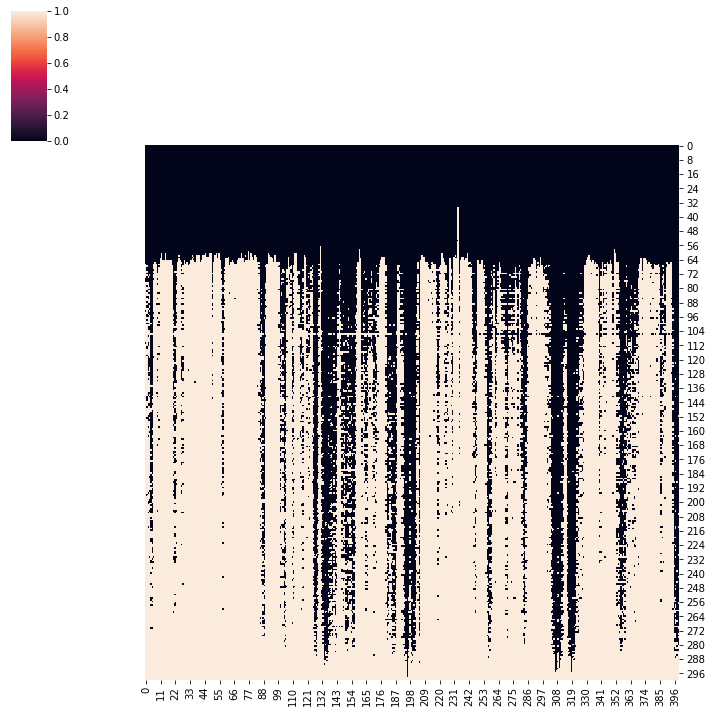

In [45]:
# visualize the inferred replication heatmap
sns.clustermap(model_rep1.detach().numpy().astype(float).T[np.argsort(time_fit_s1.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

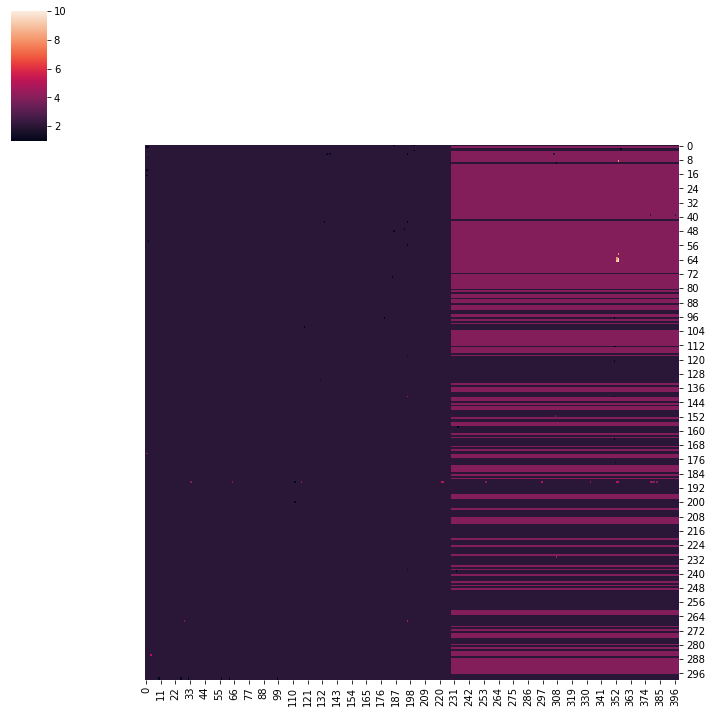

In [46]:
# visualize the inferred replication heatmap
sns.clustermap(model_cn1.detach().numpy().astype(float).T[np.argsort(time_fit_s1.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

The following output mimics the strange results seen in the snakemake pipeline of certain cells having 0 replicated bins (which is what I wanted).

Now to see if I can find a way to remedy this error.

### Fit `model_s2` (with cell-specific guesses for `u`) using the betas learned from `model_g2`

This might solve the issue of having cells with 0 replicated bins

In [47]:
@config_enumerate
def model_s2(gc_profile, libs, cn0=None, rt0=None, num_cells=None, num_loci=None, poly_degree=4, data=None, cn_prior=None, t_alpha_prior=None, t_beta_prior=None, t_init=None):
    assert (num_cells is None) != (data is None)

    if data is not None:
        num_loci, num_cells = data.shape
    elif cn0 is not None:
        num_loci, num_cells = cn0.shape
    num_libraries = int(torch.max(libs).item() + 1)

    # controls the consistency of replicating on time
    a = pyro.param('a', torch.tensor([10.]))
    
    # negative binomial dispersion
    nb_r = pyro.param('nb_r', torch.tensor([10000.0]), constraint=constraints.positive)
    
    # gc bias params
    # these should be conditioned based on fitted values for G1-phase cells
    beta_means = pyro.sample('beta_means', dist.Normal(0., 1.).expand([num_libraries, poly_degree+1]).to_event(2))
    beta_stds = pyro.param('beta_stds', torch.logspace(start=0, end=-poly_degree, steps=(poly_degree+1)).reshape(1, -1).expand([num_libraries, poly_degree+1]),
                           constraint=constraints.positive)
    
    if rt0 is not None:
        # fix rt as constant when input into model
        rt = rt0
    else:
        with pyro.plate('num_loci0', num_loci):
            # bulk replication timing profile
            rt = pyro.sample('rt', dist.Normal(torch.ones(num_loci)*0.5, 0.1))
    
    # fix cn as constant when input into model
    if cn0 is not None:
        cn = cn0

    with pyro.plate('num_cells', num_cells):
        
        # per cell replication time
        # draw from prior if provided
        if (t_alpha_prior is not None) and (t_beta_prior is not None):
            t = pyro.sample('t', dist.Beta(t_alpha_prior, t_beta_prior))
        elif t_init is not None:
            t = pyro.param('t', t_init, constraint=constraints.unit_interval)
        else:
            t = pyro.sample('t', dist.Beta(torch.tensor([1.5]), torch.tensor([1.5])))
        
        # per cell reads per copy per bin
        # u should be inversely related to t and cn, positively related to reads
        if data is not None:
            if cn0 is not None:
                cell_ploidies = torch.mean(cn0.type(torch.float32), dim=0)
            elif cn_prior is not None:
                temp_cn0 = torch.argmax(cn_prior, dim=2).type(torch.float32)
                cell_ploidies = torch.mean(temp_cn0, dim=0)
            else:
                cell_ploidies = torch.ones(num_cells) * 2.
            u_guess = torch.mean(data.type(torch.float32), dim=0) / ((1 + t) * cell_ploidies)
            # u_guess = torch.mean(data.type(torch.float32), dim=0) / cell_ploidies
        else:
            u_guess = torch.tensor([70.])
        
        u_stdev = u_guess / 10.
    
        u = pyro.sample('u', dist.Normal(u_guess, u_stdev))
        
        # sample beta params for each cell based on which library the cell belongs to
        betas = pyro.sample('betas', dist.Normal(beta_means[libs], beta_stds[libs]).to_event(1))

        with pyro.plate('num_loci', num_loci):
            
            if cn0 is None:
                if cn_prior is None:
                    cn_prior = torch.ones(num_loci, num_cells, 13)
                # sample cn probabilities of each bin from Dirichlet
                cn_prob = pyro.sample('cn_prob', dist.Dirichlet(cn_prior))
                # sample cn state from categorical based on cn_prob
                cn = pyro.sample('cn', dist.Categorical(cn_prob))

            # per cell per bin late or early 
            t_diff = t.reshape(-1, num_cells) - rt.reshape(num_loci, -1)

            # probability of having been replicated
            p_rep = 1 / (1 + torch.exp(-a * t_diff))
            
            # binary replicated indicator
            rep = pyro.sample('rep', dist.Bernoulli(p_rep))

            # copy number accounting for replication
            rep_cn = cn * (1. + rep)
            
            # copy number accounting for gc bias
            gc_features = make_gc_features(gc_profile, poly_degree=poly_degree).reshape(num_loci, 1, poly_degree+1)
            gc_rate = torch.exp(torch.sum(torch.mul(betas, gc_features), 2))
            biased_cn = rep_cn * gc_rate

            # expected reads per bin per cell
            expected_reads = (u * biased_cn)

            nb_p = expected_reads / (expected_reads + nb_r)
            reads = pyro.sample('reads', dist.NegativeBinomial(nb_r, probs=nb_p), obs=data)

In [48]:
t_init = None # no initialization for t as of now

In [49]:
pyro.clear_param_store()

optim_s2 = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo_s2 = TraceEnum_ELBO(max_plate_nesting=2)

conditioned_model_s2 = poutine.condition(
    model_s2,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
        'beta_means': beta_means_fit2,
        'beta_stds': beta_stds_fit2
    })

guide_s2 = AutoDelta(
    poutine.block(conditioned_model_s2,
                  expose=['a', 'u', 't', 'nb_r', 'rt', 'cn_prob', 'betas', 'beta_means', 'beta_stds'], 
                  hide=['rep', 'cn'])
)
svi_s2 = SVI(conditioned_model_s2, guide_s2, optim_s2, loss=elbo_s2)


In [50]:
# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model_s2, guide_s2, gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'rep', 'cn'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


307822329856.0

In [51]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi_s2.step(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')


...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

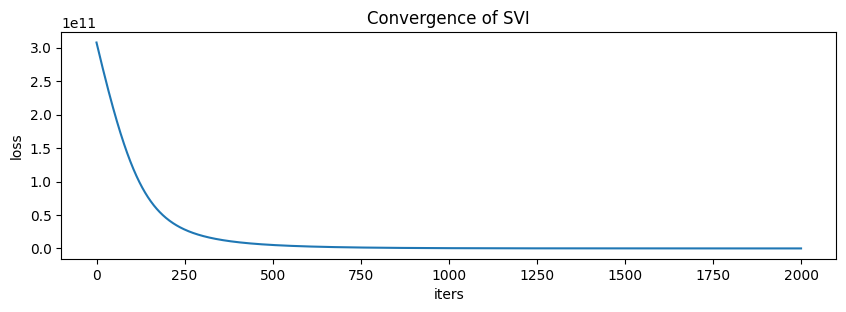

In [52]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');


In [54]:
# Plot replicated state

guide_trace_s2 = poutine.trace(guide_s2).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)
trained_model_s2 = poutine.replay(conditioned_model_s2, trace=guide_trace_s2)

inferred_model_s2 = infer_discrete(
    trained_model_s2, temperature=0,
    first_available_dim=-3)
trace_s2 = poutine.trace(inferred_model_s2).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)

# extract fitted parameters
nb_r_fit_s2 = trace_s2.nodes['nb_r']['value']
u_fit_s2 = trace_s2.nodes['u']['value']
rt_fit_s2 = trace_s2.nodes['rt']['value']
a_fit_s2 = trace_s2.nodes['a']['value']
time_fit_s2 = trace_s2.nodes['t']['value']
model_rep2 = trace_s2.nodes['rep']['value']
model_cn2 = trace_s2.nodes['cn']['value']

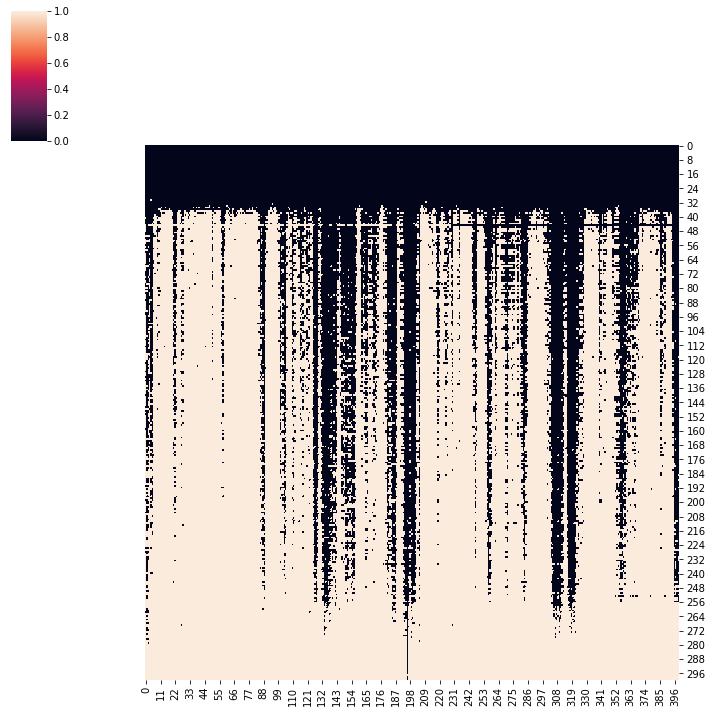

In [55]:
# visualize the inferred replication heatmap
sns.clustermap(model_rep2.detach().numpy().astype(float).T[np.argsort(time_fit_s2.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

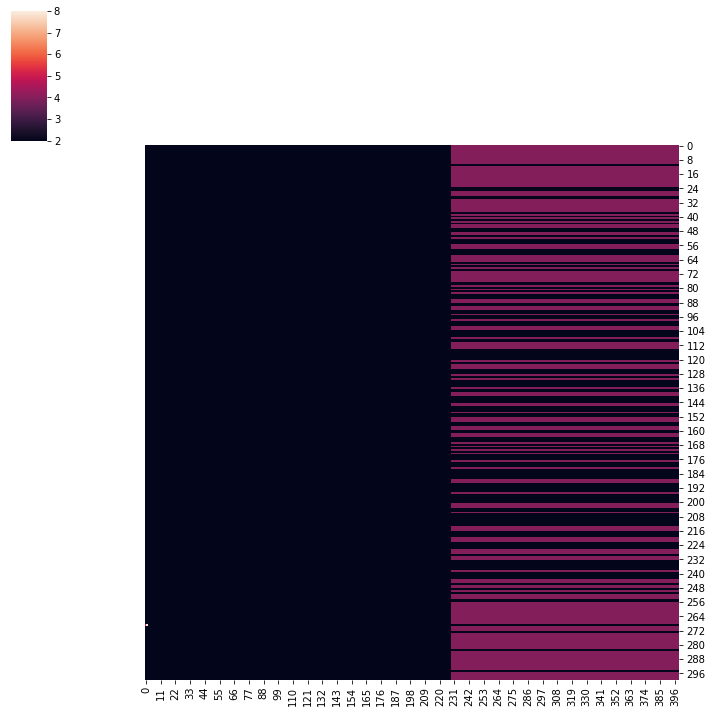

In [56]:
# visualize the inferred replication heatmap
sns.clustermap(model_cn2.detach().numpy().astype(float).T[np.argsort(time_fit_s2.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

There are still cells with no replicated bins when the `u`s are centered around cell-specific values. However there are less of these "bad" cells than the previous version of the model that has global guesses for `u` and thus gc bias curves that differ in absolute value.

### Repeat above model except with establishing an initialization for `t` of each cell based on the binarized states

In [58]:
def manhattan_binarization(X, MEAN_GAP_THRESH=0.7, EARLY_S_SKEW_THRESH=0.2, LATE_S_SKEW_THRESH=-0.2):
    # center and scale the data
    X = (X - np.mean(X)) / np.std(X)
    
    # fit a 2-state GMM to the data
    gm = GaussianMixture(n_components=2, random_state=0)
    states = gm.fit_predict(X)
    
    # use GMM means to assign binary values for thresholding
    mean_0 = gm.means_[0][0]
    mean_1 = gm.means_[1][0]

    # find the distance between the two means for each state
    mean_gap = abs(mean_0 - mean_1)

    # assume means denote binary values
    binary_0 = min(mean_0, mean_1)
    binary_1 = max(mean_0, mean_1)
    
    X = X.flatten()
    
    # use skew to define the binary values if means are close together
    if mean_gap < MEAN_GAP_THRESH:
        cell_skew = skew(X)
        print('cell_skew', cell_skew)
        # positive skew indicates early S-phase
        if cell_skew > EARLY_S_SKEW_THRESH:
            binary_0 = np.percentile(X, 50)
            binary_1 = np.percentile(X, 95)
        # negative skew indicates late S-phase
        elif cell_skew < LATE_S_SKEW_THRESH:
            binary_0 = np.percentile(X, 5)
            binary_1 = np.percentile(X, 50)
        # assume mid-S when skew is neutral
        else:
            binary_0 = np.percentile(X, 25)
            binary_1 = np.percentile(X, 75)

    # now that binary values are selected, I must compute the Manhattan distance
    # between binarized data and X for 100 different thresholds
    threshs = np.linspace(binary_0, binary_1, 100)
    lowest_dist = np.inf
    best_t = None
    manhattan_dists = []
    for t in threshs:
        # set values to binary_1 when above t, to binary_0 when below t
        B = np.where(X>t, binary_1, binary_0)
        # compute Manhattan distance between two vectors
        dist = cityblock(X, B)
        manhattan_dists.append(dist)
        if dist < lowest_dist:
            lowest_dist = dist
            best_t = t

    # binarize X based on the best threshold
    cell_rt = np.where(X>best_t, 1, 0)
    # compute fraction of replicated bins (cell's time within s-phase)
    frac_rt = sum(cell_rt) / len(cell_rt)
    
    return cell_rt, frac_rt



In [59]:
reads_norm_by_cn = cn_s_reads / torch.argmax(cn_prior, dim=2)

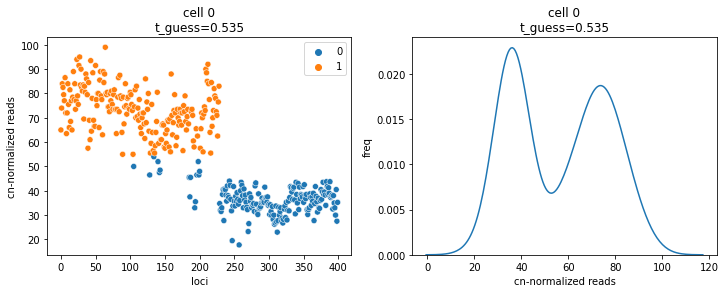

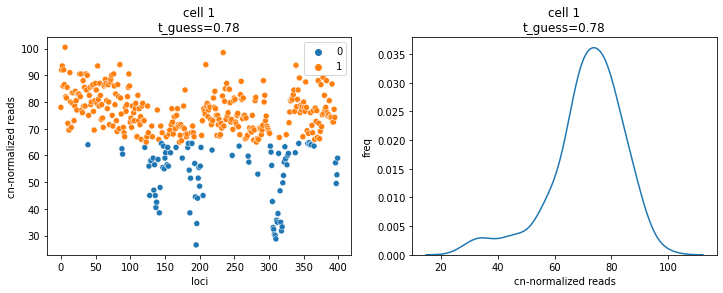

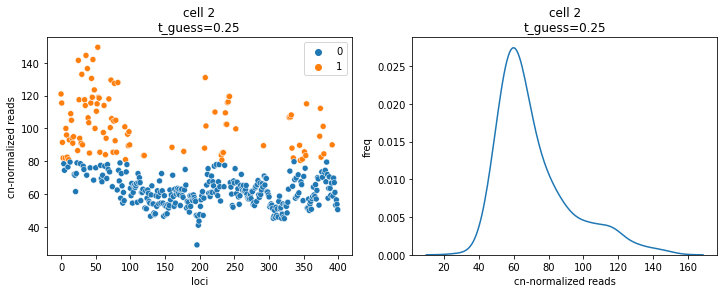

In [62]:
t_init = torch.zeros(num_cells)
t_alpha_prior = torch.zeros(num_cells)
t_beta_prior = torch.zeros(num_cells)
gamma = 6
for i in range(num_cells):
    cell_profile = reads_norm_by_cn[:, i]
    
    X = cell_profile.numpy().reshape(-1, 1)
    y_pred2, t_guess = manhattan_binarization(X)
    
    t_init[i] = t_guess
    
    alpha = t_guess * gamma
    beta = gamma - alpha
    t_alpha_prior[i] = alpha
    t_beta_prior[i] = beta
    
    if i < 3:

        fig, ax = plt.subplots(1, 2, figsize=(12, 4))

        sns.scatterplot(x=torch.arange(0, num_loci), y=cell_profile, hue=y_pred2, ax=ax[0])
        ax[0].set_xlabel('loci')
        ax[0].set_ylabel('cn-normalized reads')
        ax[0].set_title('cell {}\nt_guess={}'.format(i, round(t_guess, 3)))

        sns.kdeplot(x=cell_profile, ax=ax[1])
        ax[1].set_xlabel('cn-normalized reads')
        ax[1].set_ylabel('freq')
        ax[1].set_title('cell {}\nt_guess={}'.format(i, round(t_guess, 3)))

        plt.show()


In [63]:
pyro.clear_param_store()

optim_s3 = pyro.optim.Adam({'lr': 0.01, 'betas': [0.8, 0.99]})
elbo_s3 = TraceEnum_ELBO(max_plate_nesting=2)

conditioned_model_s3 = poutine.condition(
    model_s2,
    data={
# Uncomment to condition on various hidden variables
#         'a': torch.tensor([10.]),
#         'rep': rep,
#         't': t,
#         'rt': rt,
#         'nb_r': nb_r,
#         'cn': cn,
#         'u': u
        'beta_means': beta_means_fit2,
        'beta_stds': beta_stds_fit2
    })

guide_s3 = AutoDelta(
    poutine.block(conditioned_model_s3,
                  expose=['a', 'u', 't', 'nb_r', 'rt', 'cn_prob', 'betas', 'beta_means', 'beta_stds'], 
                  hide=['rep', 'cn'])
)
svi_s3 = SVI(conditioned_model_s3, guide_s3, optim_s3, loss=elbo_s3)


In [64]:
# Calculate initial loss

pyro.clear_param_store()

elbo.loss(conditioned_model_s3, guide_s3, gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)


/juno/work/shah/users/weinera2/projects/scdna_replication_tools/venv/lib/python3.7/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'rep', 'cn'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


307823673344.0

In [65]:
# Learn the model and guide params

pyro.clear_param_store()

losses = []
for i in range(2000):
    loss = svi_s3.step(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)
    losses.append(loss)
    print('.' if i % 80 else '\n', end='')


...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
.......................................

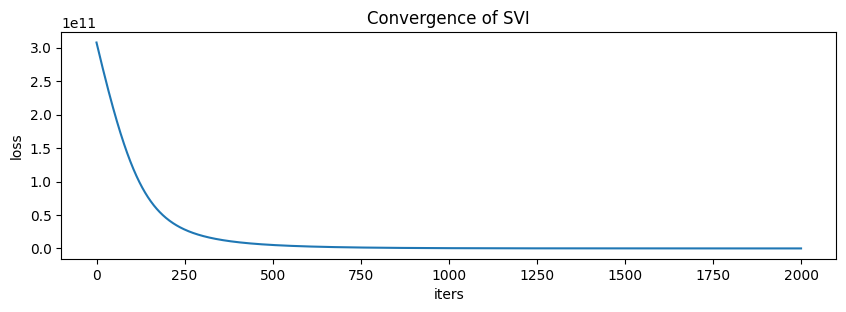

In [66]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
# plt.yscale('log')
plt.title('Convergence of SVI');


In [67]:
# Plot replicated state

guide_trace_s3 = poutine.trace(guide_s3).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)
trained_model_s3 = poutine.replay(conditioned_model_s3, trace=guide_trace_s3)

inferred_model_s3 = infer_discrete(
    trained_model_s3, temperature=0,
    first_available_dim=-3)
trace_s3 = poutine.trace(inferred_model_s3).get_trace(gc_profile, libs_s, data=cn_s_reads, cn_prior=cn_prior, t_init=t_init)

# extract fitted parameters
nb_r_fit_s3 = trace_s3.nodes['nb_r']['value']
u_fit_s3 = trace_s3.nodes['u']['value']
rt_fit_s3 = trace_s3.nodes['rt']['value']
a_fit_s3 = trace_s3.nodes['a']['value']
time_fit_s3 = trace_s3.nodes['t']['value']
model_rep3 = trace_s3.nodes['rep']['value']
model_cn3 = trace_s3.nodes['cn']['value']

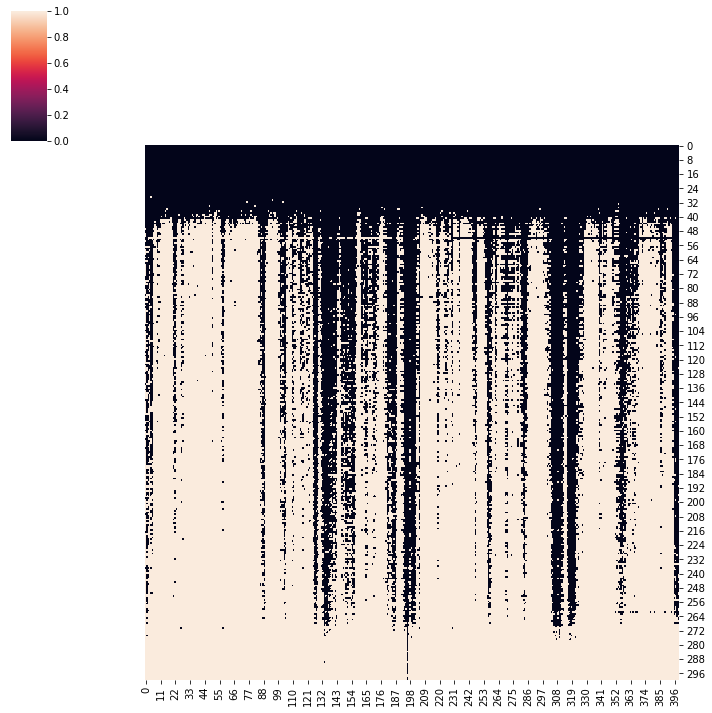

In [68]:
# visualize the inferred replication heatmap
sns.clustermap(model_rep3.detach().numpy().astype(float).T[np.argsort(time_fit_s3.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()

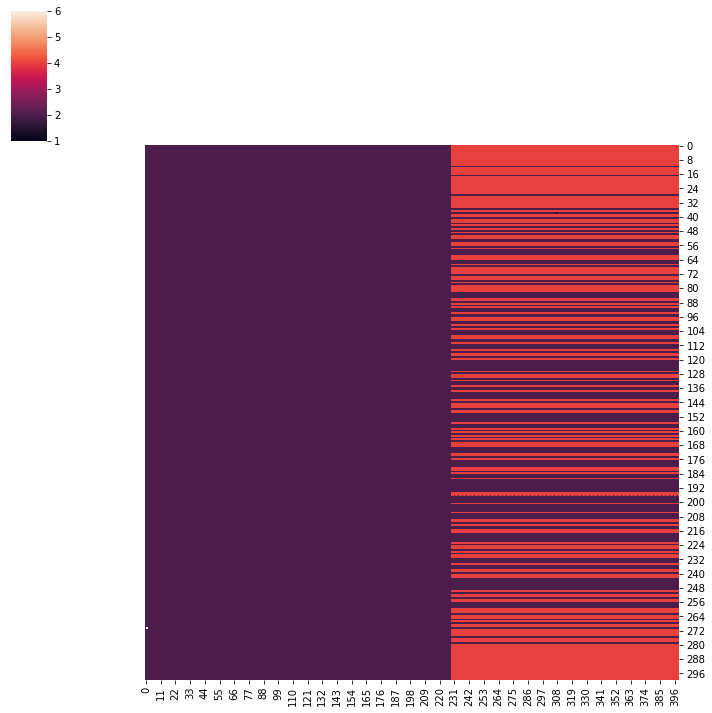

In [69]:
# visualize the inferred replication heatmap
sns.clustermap(model_cn3.detach().numpy().astype(float).T[np.argsort(time_fit_s3.detach().numpy()), :], col_cluster=False, row_cluster=False)
plt.show()